# The Vintage Haven (RFM Customer Segmentation)
Dataset Source: Chen, D. (2015). Online Retail [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5BW33.  
Author: Klaudia Rapa   
Date: 24/11/2025

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. 

## 1. Import Packages and Data

In [507]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz
from sklearn.cluster import AgglomerativeClustering

In [508]:
# Import data
raw_data = pd.read_excel("/Users/klaudiarapa/Desktop/RFM Customer Segmentation/Online Retail.xlsx")

## 2. Data Cleaning

The first step is to get an overview and clean the dataset.

We aim to understand:  
- Which columns are present and their data types  
- The size of the dataset (number of rows and columns)  

Next, we will assess data quality by checking for missing values and inspecting a small sample of the dataset.

In [511]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [512]:
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


The raw dataset contains **541,909 rows and 8 columns**.  
The data types are appropriate and the dataset is ready for further analysis.

#### **Missing data exploration** 

We examined the dataset for missing values to assess data completeness and identify potential issues.

In [516]:
# Print count of missing data per column
raw_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There is **135,080 rows with missing Customer ID**. Since these records cannot be used for customer segmentation, we will drop them.

A potential solution could be to assign Customer IDs using other data sources, such as matching by InvoiceID, if feasible.

In [518]:
# Drop rows with missing Customer ID
raw_data = raw_data.dropna(subset=["CustomerID"])

In [519]:
# Missing data exploration
raw_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

After removing the rows with missing Customer ID, there are no remaining missing values in the dataset.
It’s worth noting that some of the excluded rows also had missing **Description** values.

#### **Cancelled Invoices**

The dataset documentation indicates that **some invoices were cancelled**, which can be identified by invoice numbers starting with "C".
These records should be excluded from the RFM analysis because **cancelled transactions do not reflect actual customer purchasing behavior**.

In [523]:
# Printing rows with cancelled invoices
raw_data[raw_data["InvoiceNo"].astype(str).str.startswith("C")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [524]:
# Removing the cancelled invoices
raw_data = raw_data[~raw_data["InvoiceNo"].astype(str).str.startswith("C")]

#### **Duplicated records**

**Duplicate records were identified** in the dataset and removed.
Keeping duplicates could lead to artificially inflating purchase frequency and monetary values.

In [527]:
# -----------------------------------------------------------
# Step 1: Identify and display duplicate rows before dropping
# -----------------------------------------------------------

# Mark all duplicates (keep=False marks all occurrences)
duplicate_rows = raw_data[raw_data.duplicated(keep=False)]

# Show the total number of duplicate rows
print(f"Total duplicate rows found: {duplicate_rows.shape[0]}")

Total duplicate rows found: 10001


In [528]:
# Drop duplicates
clean_data = raw_data.drop_duplicates()

#### **How did the cleaning affect the data shape?**

In [530]:
print("Shape after cleaning:", clean_data.shape)

Shape after cleaning: (392732, 8)


After cleaning, the dataset contains **392 732 rows and 8 columns**, which represents **72.47% of the original dataset**.
During the cleaning process, we excluded:

- **135,080 rows** with missing Customer ID
- **8,908 rows** corresponding to cancelled invoices (InvoiceNo starting with "C")
- **10,001** duplicate rows

The largest portion of removed data is due to missing Customer IDs, which warrants further investigation to understand the underlying cause.

## 3. Data Exploration

### **Quantity**

**To better understand customer purchasing behavior**, we first examine the Quantity of items ordered.
Using descriptive statistics provides insight into **the typical order size, the spread of values, and the presence of extreme orders**.  

This helps us identify natural breaks in the data, justify segmentation, and detect any unusual or outlier orders.

In [535]:
# Calculating statistics for Quantity
clean_data['Quantity'].describe()

count    392732.000000
mean         13.153718
std         181.588420
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [536]:
# Percentiles
percentiles = [0, 0.25, 0.5, 0.75, 0.9, 0.99, 1.0]
clean_data['Quantity'].quantile(percentiles)

0.00        1.0
0.25        2.0
0.50        6.0
0.75       12.0
0.90       24.0
0.99      120.0
1.00    80995.0
Name: Quantity, dtype: float64

The distribution of order quantities is highly skewed: the majority of customers place relatively small orders (90% are 24 units or fewer), while only 1% of orders exceed 120 units. This supports our decision to segment customers into three groups — Individuals (<20 units), Small B2B (20–100 units), and Wholesalers (>100 units) — so that the RFM analysis fairly reflects different purchasing behaviors. Based on data exploration and discussions with stakeholders, we identified three distinct customer groups:

1. **Individual customers:** purchase fewer than 20 units
2. **Small B2B businesses:** purchase between 20 and 100 units
3. **Wholesalers:** purchase more than 100 units

Since the RFM method can be biased when applied to customers with such different purchasing patterns - favoring wholesalers due to their larger volumes - **we decided to segment the customers into these groups** before calculating RFM scores.

**Mistake:** first I classified customers just based on the Quantity - which led to assigning different Customer Types to the same customer. Identified that mistake during further data exploration and fixed that by assigning Customer Types based on average Quantity per Customer. 

clean_data['Customer Type'] = np.where(
    clean_data['Quantity'] >= 100, 'Wholesalers',
    np.where(clean_data['Quantity'] >= 20, 'Small B2B', 'Individual')
)

In [539]:
customer_quantity = clean_data.groupby('CustomerID')['Quantity'].agg(['sum','mean','max']).reset_index()
customer_quantity.head()

,CustomerID,sum,mean,max
0,12346.0,74215,74215.000000,74215
1,12347.0,2458,13.505495,240
2,12348.0,2341,75.516129,144
3,12349.0,631,8.643836,36
4,12350.0,197,11.588235,24


In [540]:
def classify_customer(avg_qty):
    if avg_qty < 20:
        return "Individual"
    elif avg_qty < 100:
        return "Small B2B"
    else:
        return "Wholesaler"

customer_quantity['Customer Type'] = customer_quantity['mean'].apply(classify_customer)

In [541]:
clean_data = clean_data.merge(customer_quantity[['CustomerID','Customer Type']], on='CustomerID', how='left')

In [542]:
clean_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer Type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Individual
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Individual
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual
...,...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,Individual
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,Individual
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,Individual
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,Individual


Number of orders per group:
Customer Type
Individual    355345
Small B2B      32743
Wholesaler      4644
Name: count, dtype: int64

Percentage of orders per group:
Customer Type
Individual    90.480277
Small B2B      8.337238
Wholesaler     1.182486
Name: proportion, dtype: float64


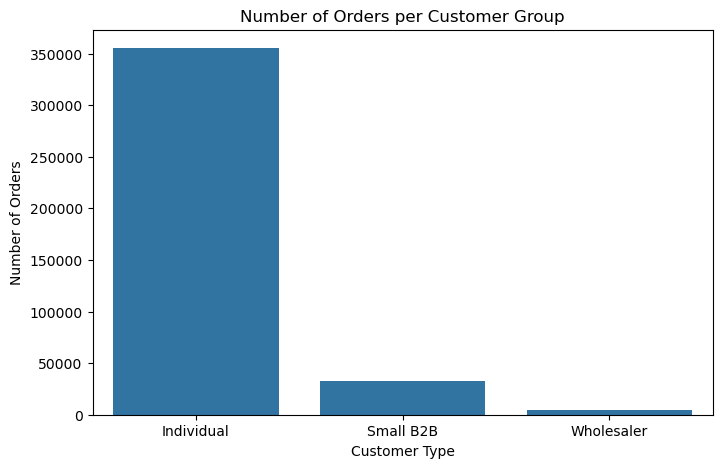

In [543]:
# Count number of orders per customer group
group_counts = clean_data['Customer Type'].value_counts().sort_index()
print("Number of orders per group:")
print(group_counts)

# Optional: show percent of total for each group
group_percent = clean_data['Customer Type'].value_counts(normalize=True).sort_index() * 100
print("\nPercentage of orders per group:")
print(group_percent)

# Optional: visualize distribution per group
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=clean_data, x='Customer Type', order=['Individual','Small B2B','Wholesaler'])
plt.title('Number of Orders per Customer Group')
plt.ylabel('Number of Orders')
plt.show()

Number of orders per Wholesaler:
CustomerID
12415.0    716
13694.0    568
18102.0    431
17450.0    336
16684.0    277
          ... 
18084.0      1
13270.0      1
13366.0      1
16737.0      1
15195.0      1
Name: count, Length: 107, dtype: int64


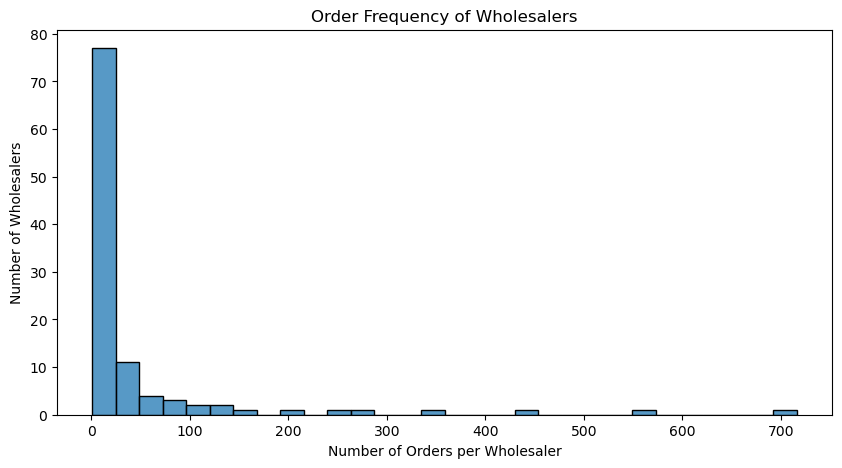

In [544]:
# Filter Wholesalers
wholesalers = clean_data[clean_data["Customer Type"] == "Wholesaler"]

# Count number of orders per Wholesaler
orders_per_wholesaler = wholesalers['CustomerID'].value_counts().sort_values(ascending=False)

print("Number of orders per Wholesaler:")
print(orders_per_wholesaler)

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(orders_per_wholesaler, bins=30, kde=False)
plt.xlabel('Number of Orders per Wholesaler')
plt.ylabel('Number of Wholesalers')
plt.title('Order Frequency of Wholesalers')
plt.show()


### **Unit Price**

To understand the value of individual products, we examine the UnitPrice column.

Descriptive statistics help us see **the typical price, the range of prices, and any extremely high or low values**.
This information is useful for identifying pricing patterns, detecting outliers, and supporting customer or product segmentation.

In [547]:
clean_data['UnitPrice'].describe()

count    392732.000000
mean          3.125596
std          22.240725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

The unit price distribution shows that **most products are priced quite low, but there are a few extremely expensive items**:

The average unit price is around 3.13, but the standard deviation is very high (22.24), indicating wide variability.

Most products are inexpensive:
- 25% of orders are <= 1.25
- 50% (median) are <= 1.95
- 75% are <= 3.75

**The minimum price is 0, and the maximum price is 8,142.75, showing a few extreme outliers.**

The majority of orders are for low-priced items, while a small number of very expensive products significantly increase the mean and standard deviation. **This skewed distribution suggests that when analyzing revenue or monetary value, extreme prices may dominate unless handled carefully.**

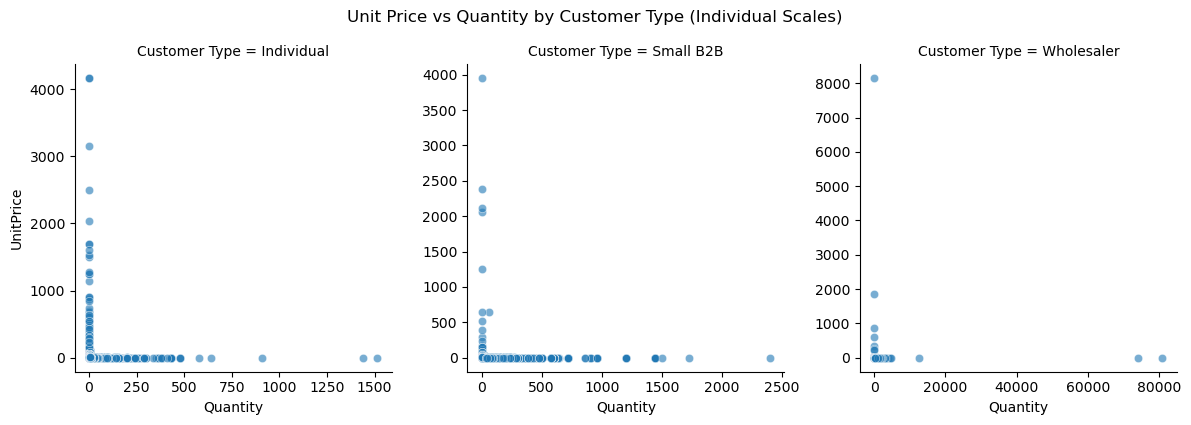

In [549]:
g = sns.FacetGrid(
    clean_data, 
    col="Customer Type", 
    col_wrap=3, 
    height=4,
    sharex=False,
    sharey=False      # <- THIS gives each facet its own scale
)

g.map_dataframe(
    sns.scatterplot, 
    x="Quantity", 
    y="UnitPrice", 
    alpha=0.6
)

g.fig.suptitle("Unit Price vs Quantity by Customer Type (Individual Scales)", y=1.05)
plt.show()

In [550]:
clean_data[clean_data['UnitPrice'] > 1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer Type
75227,546328,M,Manual,1,2011-03-11 10:19:00,1687.17,14911.0,EIRE,Individual
75228,546329,M,Manual,1,2011-03-11 10:22:00,1687.17,14911.0,EIRE,Individual
95766,548813,M,Manual,1,2011-04-04 13:03:00,2382.92,12744.0,Singapore,Small B2B
95768,548813,M,Manual,1,2011-04-04 13:03:00,1252.95,12744.0,Singapore,Small B2B
95769,548820,M,Manual,1,2011-04-04 13:04:00,2053.07,12744.0,Singapore,Small B2B
96290,548913,M,Manual,1,2011-04-05 09:45:00,1136.30,12669.0,France,Individual
100163,549468,M,Manual,1,2011-04-08 14:27:00,1867.86,17940.0,United Kingdom,Wholesaler
116879,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,Wholesaler
137658,554155,M,Manual,1,2011-05-23 11:26:00,1241.98,12757.0,Portugal,Individual
138324,554301,M,Manual,1,2011-05-23 14:46:00,1241.98,12757.0,Portugal,Individual


The graphs reveal that **some unit prices are extremely high**. Examining these transactions shows that the *Description* is often vague, such as "Manual" or "DOTCOM POSTAGE", making it difficult to determine whether these values are errors. Because we cannot verify them, **we will retain these data points**, but we should keep in mind that such extreme values exist and **may influence certain analyses**.

### **Country**

The store is primarily located in the UK, which is also home to the majority of its customers; however, customers are spread across 37 different countries.

In [554]:
clean_data["Country"].describe()

count             392732
unique                37
top       United Kingdom
freq              349227
Name: Country, dtype: object

Let’s take a closer look at the geographic distribution of orders across countries.

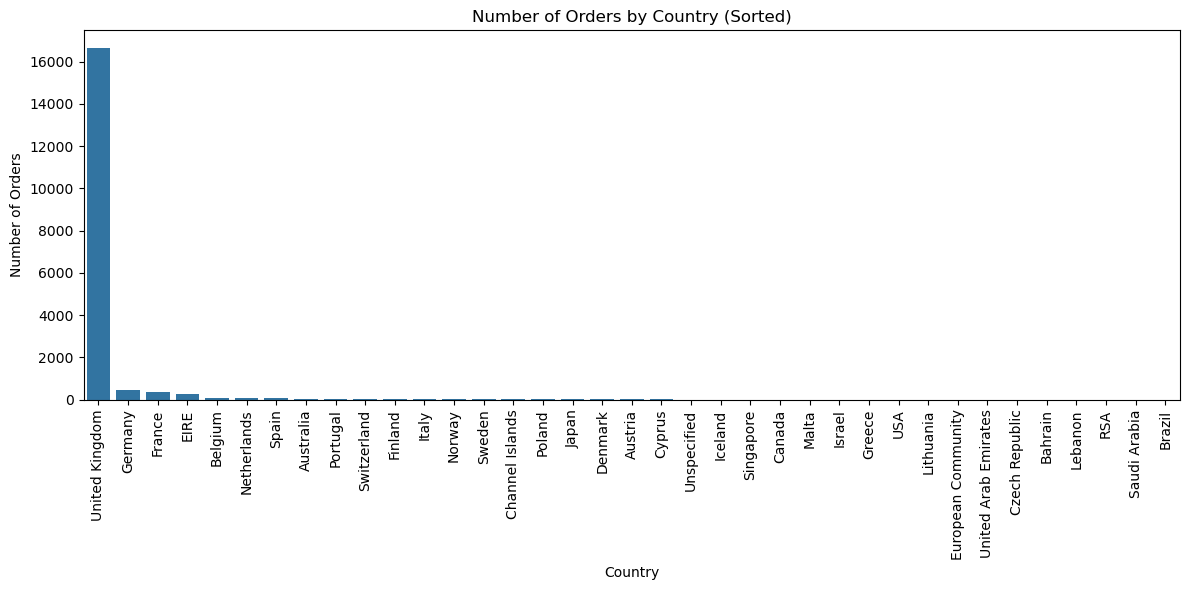

In [556]:
# Count number of orders per country
country_orders = clean_data.groupby("Country", as_index=False)["InvoiceNo"].nunique()

# Rename column for clarity
country_orders.rename(columns={"InvoiceNo": "Number of Orders"}, inplace=True)

# Sort by number of orders descending
country_orders = country_orders.sort_values(by="Number of Orders", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=country_orders, x="Country", y="Number of Orders", ax=ax)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.title("Number of Orders by Country (Sorted)")
plt.tight_layout()
plt.show()



The main market is the UK, with 16,000 orders. We now want to explore which other countries contribute most to sales.

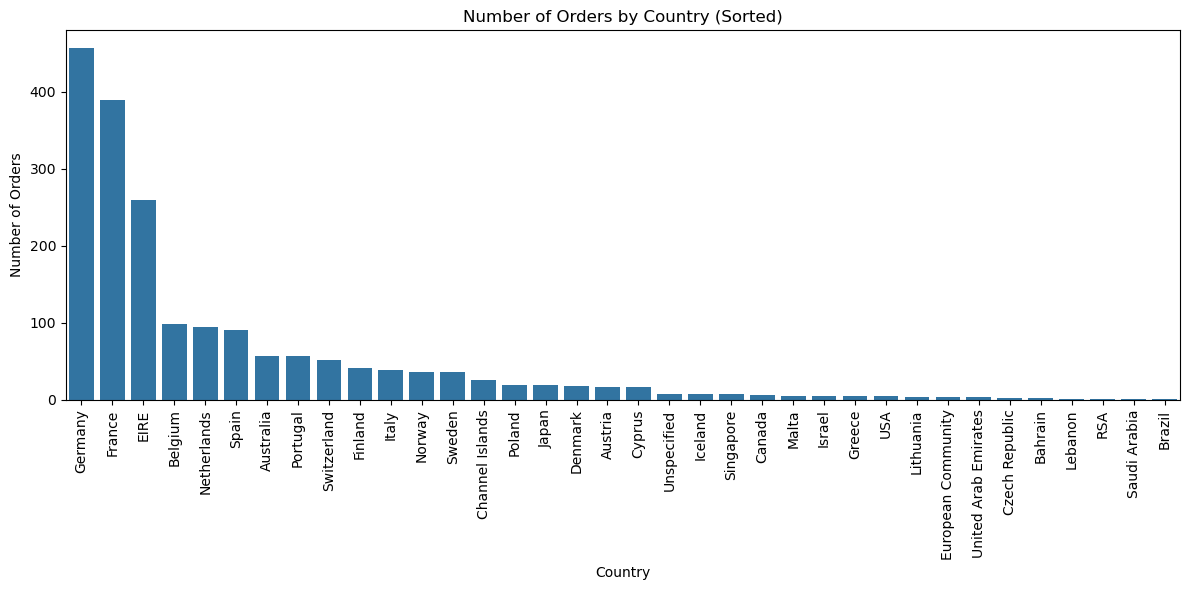

In [558]:
# Count number of orders per country
country_orders = clean_data.groupby("Country", as_index=False)["InvoiceNo"].nunique()

# Rename column for clarity
country_orders.rename(columns={"InvoiceNo": "Number of Orders"}, inplace=True)

# Sort by number of orders descending
country_orders = country_orders.sort_values(by="Number of Orders", ascending=False)

#Exclude UK 
country_orders = country_orders[country_orders["Country"] != "United Kingdom"]

# Plot
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=country_orders, x="Country", y="Number of Orders", ax=ax)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.title("Number of Orders by Country (Sorted)")
plt.tight_layout()
plt.show()


Excluding the UK, the top three countries by number of orders are Germany, France, and Ireland.

### **Product (Description)**

To understand customer preferences and identify high-demand items, we examine the Description column, which lists all products in the dataset. By analyzing which products are ordered most frequently or in the highest quantities, we can uncover best-selling items and gain insights for marketing and promotional strategies.

In [562]:
clean_data["Description"].describe()

count                                 392732
unique                                  3877
top       WHITE HANGING HEART T-LIGHT HOLDER
freq                                    2016
Name: Description, dtype: object

The product range is very wide and various. There are 3877 unique product descriptions. The most popular 50 products are displayed on the graph below. 

Automatic Merging of Similar Product Descriptions

The dataset contains 3 877 unique product descriptions, some of which are duplicates or slightly different spellings of the same item. To clean the data for analysis, we applied an automated string similarity and clustering approach:

- Compute pairwise similarity of all unique product descriptions using RapidFuzz with token-based string comparison.
- Convert similarity to distance for clustering.
- Cluster similar descriptions using agglomerative clustering (sklearn), so that descriptions with high similarity (e.g., >90%) are grouped together.
- Assign a representative name to each cluster, typically the most frequent description within the cluster.
- Map all orders to the cleaned product descriptions to create a consistent Description_Clean column.

This approach ensures that near-duplicate product names are merged automatically, reducing noise in the analysis of the most popular products, without manually inspecting thousands of entries.

In [565]:
# Get unique product descriptions
products = clean_data['Description'].unique()

# Build a similarity matrix (token_sort_ratio)
n = len(products)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        score = fuzz.token_sort_ratio(products[i], products[j])
        similarity_matrix[i, j] = score
        similarity_matrix[j, i] = score

# Convert similarity to distance (needed for clustering)
distance_matrix = 100 - similarity_matrix

# Cluster similar products
clustering = AgglomerativeClustering(
    n_clusters=None,            # let threshold decide
    metric='precomputed',       # instead of affinity
    linkage='complete',
    distance_threshold=10       # adjust threshold (10 = 90% similarity)
)
labels = clustering.fit_predict(distance_matrix)


# Map original descriptions to cluster labels
product_clusters = pd.DataFrame({'Description': products, 'Cluster': labels})

# Create a representative name for each cluster (e.g., most frequent description)
cluster_map = product_clusters.groupby('Cluster')['Description'].agg(lambda x: x.value_counts().index[0]).to_dict()

# Map original data to cleaned description
clean_data['Description_Clean'] = clean_data['Description'].map(lambda x: cluster_map[product_clusters[product_clusters['Description']==x]['Cluster'].values[0]])


In [566]:
clean_data["Description_Clean"].describe()

count                                 392732
unique                                  3608
top       WHITE HANGING HEART T-LIGHT HOLDER
freq                                    2016
Name: Description_Clean, dtype: object

The number of unique products was reduced from 3877 to 3608. We are going to keep both columns in the dataset to further manually validate it in PowerBI. 

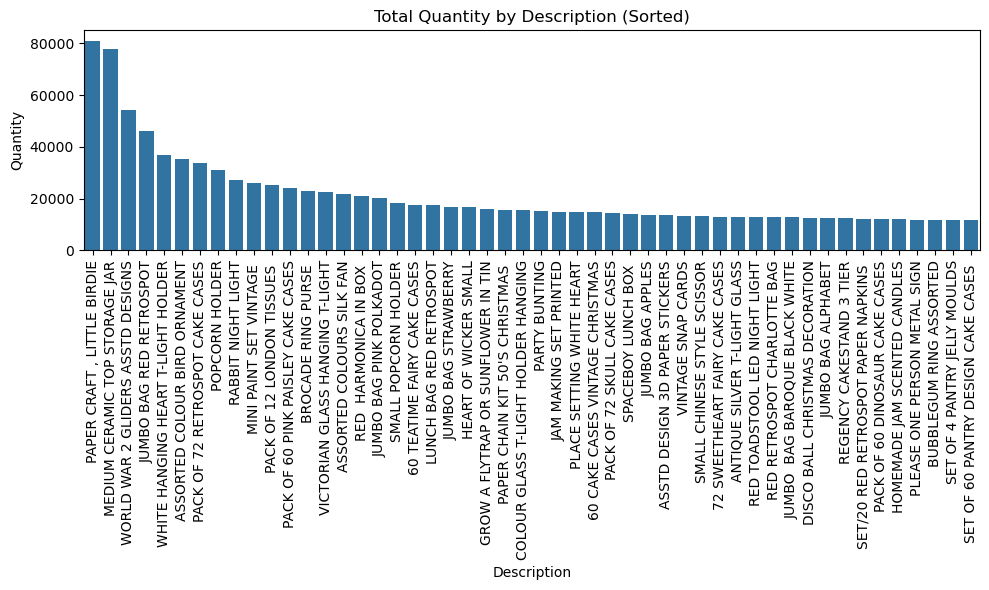

In [568]:
# Aggregate total Quantity per Product
product_agg = clean_data.groupby("Description", as_index=False)["Quantity"].sum()

# Sort by Quantity descending
product_agg = product_agg.sort_values(by="Quantity", ascending=False).head(50)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=product_agg, x="Description", y="Quantity", ax=ax)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.title("Total Quantity by Description (Sorted)")
plt.tight_layout()
plt.show()

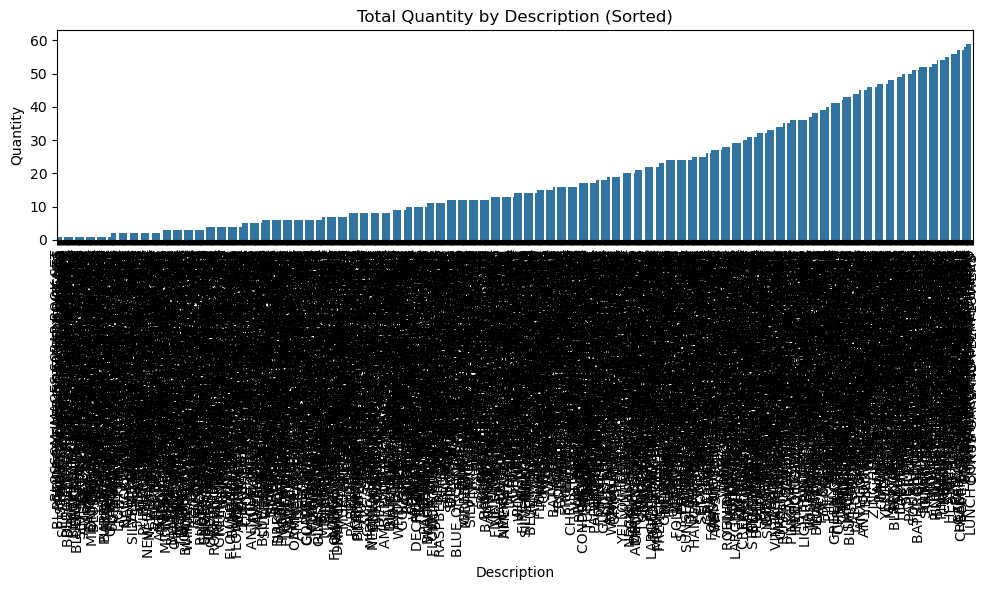

In [569]:
# Aggregate total Quantity per Product
product_agg = clean_data.groupby("Description", as_index=False)["Quantity"].sum()

# Sort by Quantity descending
product_agg = product_agg.sort_values(by="Quantity", ascending=True).head(1000)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=product_agg, x="Description", y="Quantity", ax=ax)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.title("Total Quantity by Description (Sorted)")
plt.tight_layout()
plt.show()

In [570]:
product_agg[product_agg['Quantity'] <100].count()

Description    1000
Quantity       1000
dtype: int64

The company carries 3608 different products, of which 1,000 sold fewer than 100 units over the past year. Unless these items are unique, one-off acquisitions - such as rare vintage pieces that sell quickly—it may be beneficial to reduce the breadth of the product assortment. Maintaining inventory for items with consistently low demand increases storage costs without delivering proportional revenue.

To address this, the company could consider discounting the least popular products and promoting them through targeted marketing campaigns. This would help clear out slow-moving inventory, free up storage space, and improve overall inventory efficiency.

### **Invoice Date**

We will examine how the number of orders changes over time to identify any visible trends or seasonal patterns. By breaking down the data by customer type, we can also observe how purchasing behavior differs among Individuals, Small B2B businesses, and Wholesalers. This analysis will help us understand temporal dynamics in sales and guide targeted strategies for each customer segment.

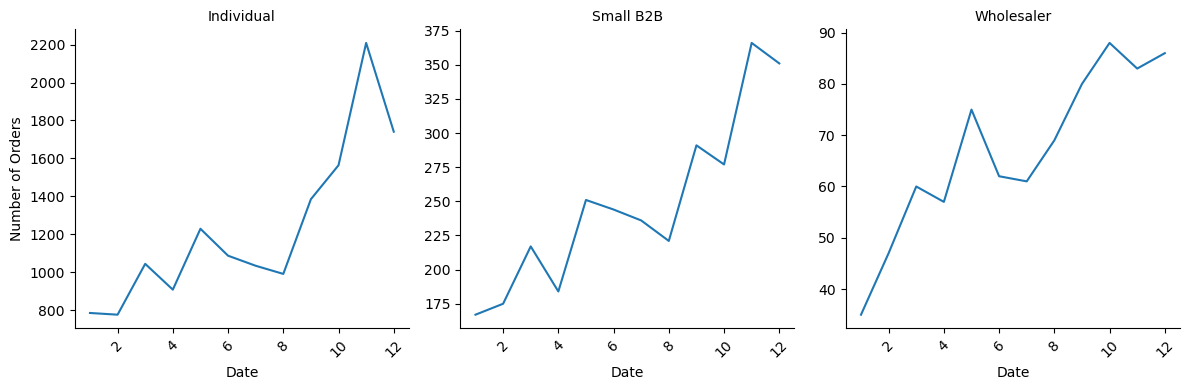

In [574]:
# Prepare the aggregated data
orders_per_day_type = (
    clean_data.groupby([clean_data['InvoiceDate'].dt.month, 'Customer Type'])['InvoiceNo']
    .nunique()
    .reset_index()
)
orders_per_day_type.rename(columns={'InvoiceNo': 'Number of Orders', 'InvoiceDate': 'Date'}, inplace=True)

# Create FacetGrid
g = sns.FacetGrid(orders_per_day_type, col="Customer Type", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Date", y="Number of Orders")
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Number of Orders")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


For all customer groups, November is the busiest month—probably because of the Christmas season and people buying gifts. Orders gradually pick up throughout the year, with January and February being the slowest. This tells us that the company should start stocking up and ramping up marketing in September and October to be ready for the November–December rush.

# 4. Feature Engineering

To prepare the dataset for advanced analysis, we created several additional columns:

- Total Transaction Value (TotalPrice) – calculated as Quantity × UnitPrice. This represents the monetary value of each order and is essential for monetary-based metrics in RFM analysis and revenue reporting.
- Reference Date (ref_date) – a fixed date used to calculate recency for each customer. By having a consistent reference point, we can accurately measure the number of days since a customer’s last purchase.
- Date and Time Columns – derived from the InvoiceDate, including year, month, and day. These allow us to: Analyze seasonal trends and monthly/weekly patterns in orders. Segment transactions by time of day or day of week for more granular insights.


These additional columns enrich the dataset, enabling more precise customer segmentation, time-based analysis, and monetary calculations. Without them, it would be difficult to calculate recency, track revenue contributions, or uncover temporal trends in customer behavior.

In [578]:
# Create total transaction value
clean_data['TotalPrice'] = clean_data['Quantity'] * clean_data['UnitPrice']

In [579]:
# Create Reference Date (day after last transaction)
ref_date = clean_data['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Reference date:", ref_date)

Reference date: 2011-12-10 12:50:00


In [580]:
# Divide "Invoice Date" into two separate columns
clean_data["Date"] = clean_data['InvoiceDate'].dt.date
clean_data["Time"] = clean_data['InvoiceDate'].dt.time

In [581]:
clean_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer Type,Description_Clean,TotalPrice,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Individual,WHITE HANGING HEART T-LIGHT HOLDER,15.30,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual,WHITE METAL LANTERN,20.34,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Individual,CREAM CUPID HEARTS COAT HANGER,22.00,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual,KNITTED UNION FLAG HOT WATER BOTTLE,20.34,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual,RED WOOLLY HOTTIE WHITE HEART.,20.34,2010-12-01,08:26:00


In [582]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392732 entries, 0 to 392731
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392732 non-null  object        
 1   StockCode          392732 non-null  object        
 2   Description        392732 non-null  object        
 3   Quantity           392732 non-null  int64         
 4   InvoiceDate        392732 non-null  datetime64[ns]
 5   UnitPrice          392732 non-null  float64       
 6   CustomerID         392732 non-null  float64       
 7   Country            392732 non-null  object        
 8   Customer Type      392732 non-null  object        
 9   Description_Clean  392732 non-null  object        
 10  TotalPrice         392732 non-null  float64       
 11  Date               392732 non-null  object        
 12  Time               392732 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), 

The final dataset after cleaning and adding new columns, we have 392 732 rows and 13 columns.

# 5. RFM Calculation

To better understand customer behavior and segment the customer base, we apply **RFM (Recency, Frequency, Monetary)** analysis. This method quantifies:

- **Recency (R)**: how recently a customer made a purchase, calculated as the number of days since their last order relative to a reference date.
- **Frequency (F)**: how often a customer places orders, measured by the number of unique invoices.
- **Monetary (M)**: the total value of a customer’s purchases, summed from TotalPrice.

Because our dataset includes Individuals, Small B2B, and Wholesalers, RFM metrics can be biased if calculated across all customers together - for example, wholesalers naturally have higher frequency and monetary values. By segmenting customers into these groups, we ensure the RFM analysis fairly reflects different purchasing behaviors and provides meaningful insights for each type.

Before scoring, we calculate for each CustomerID:

- Recency: Days since the last purchase relative to a chosen reference date.
- Frequency: Number of unique invoices per customer.
- Monetary: Total spend (sum of TotalPrice).

This produces one RFM record per customer.

In [587]:
rfm = clean_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).reset_index()

In [588]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [589]:
# Keep one Customer Type per CustomerID (assuming each customer has a consistent type)
customer_types = clean_data[['CustomerID', 'Customer Type']].drop_duplicates()

# Merge into rfm
rfm = rfm.merge(customer_types, on='CustomerID', how='left')

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Customer Type
0,12346.0,326,1,77183.60,Wholesaler
1,12347.0,2,7,4310.00,Individual
2,12348.0,75,4,1797.24,Small B2B
3,12349.0,19,1,1757.55,Individual
4,12350.0,310,1,334.40,Individual


### RFM Scoring (1–5 scale)

To transform raw RFM values into categorical scores, we assign each customer a value from 1 to 5, where:
- 5 = best performance
- 1 = weakest performance

**Why scoring is done within each customer type?**

Wholesalers purchase more frequently and in larger amounts than Individual customers.
To avoid biased scoring, we compute quantile-based scores separately within:
- Individual customers
- Small B2B customers
- Wholesalers

This ensures that each segment is compared fairly within its peer group.

In [592]:
# Function to safely assign quintiles within each group

def score_quintile_rank(x, ascending=True):
    # percentile rank (0–1)
    pct = x.rank(method="average", pct=True)

    # if lower values should get higher score (Recency)
    if ascending:
        pct = 1 - pct

    # convert percentile into 5 bins
    return (pct * 5).apply(lambda v: min(max(int(np.ceil(v)), 1), 5))


In [593]:
# Recency: lower is better
rfm['R_score'] = (
    rfm.groupby('Customer Type')['Recency']
       .transform(lambda x: score_quintile_rank(x, ascending=True))
)

In [594]:
# Frequency: higher is better, handle duplicates
rfm['F_score'] = (
    rfm.groupby('Customer Type')['Frequency']
       .transform(lambda x: score_quintile_rank(x, ascending=False))
)

In [639]:
# Monetary: higher is better
rfm['M_score'] = (
    rfm.groupby('Customer Type')['Monetary']
       .transform(lambda x: score_quintile_rank(x, ascending=False))
)

In [641]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Customer Type,R_score,F_score,M_score
0,12346.0,326,1,77183.60,Wholesaler,1,1,5
1,12347.0,2,7,4310.00,Individual,5,5,5
2,12348.0,75,4,1797.24,Small B2B,3,4,4
3,12349.0,19,1,1757.55,Individual,4,1,4
4,12350.0,310,1,334.40,Individual,1,1,2


# 6. Customer Segment Mapping

After calculating:
- R_score (1–5)
- F_score (1–5)
- M_score (1–5)

We assign each customer a marketing segment based on classical RFM rules.

- **Champions** - High R, F, M → most loyal, highest spenders, purchase very recently.
- **Loyal** - Buy frequently and repeatedly; stable purchasing patterns.
- **Potential Loyalists** -	Growing customers showing positive recency and frequency trends.
- **Recent Customers** - Recently acquired; good recency but low frequency so far.
- **At Risk but Valuable** - High historical frequency/monetary value but poor recency → high churn risk.
- **At Risk / Lost** -	Low recency and low frequency; likely inactive or churned.
- **Others Customers** - who do not fit cleanly into one of the stronger behavioural patterns.

These segments translate raw purchasing data into clear, actionable customer profiles.

In [643]:
def segment_customer(df):
    R, F, M = df['R_score'], df['F_score'], df['M_score']

    # 1. Champions — highest engagement & value
    if R >= 4 and F >= 4 and M >= 4:
        return 'Champions'

    # 2. Loyal — frequent buyers, often recent, but not top spenders
    elif R >= 4 and F >= 3:
        return 'Loyal'

    # 3. Potential Loyalists — good frequency or monetary, decent recency
    elif R >= 3 and (F >= 3 or M >= 3):
        return 'Potential Loyalist'

    # 4. Recent Customers — just purchased but haven't built frequency yet
    elif R >= 4 and F <= 2:
        return 'Recent Customers'

    # 5. At Risk but Valuable — previously good F or M
    elif R <= 2 and (F >= 4 or M >= 4):
        return 'At Risk but Valuable'

    # 6. At Risk / Lost — low on all metrics
    elif R <= 2 and F <= 2:
        return 'At Risk / Lost'

    # 7. Everything else
    else:
        return 'Others'


In [645]:
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

In [647]:
rfm.groupby('Segment')['CustomerID'].count()

Segment
At Risk / Lost           918
At Risk but Valuable     491
Champions               1005
Loyal                    506
Others                   559
Potential Loyalist       658
Recent Customers         202
Name: CustomerID, dtype: int64

Finally, we merge the RFM data back into the full transaction dataset so that every transaction row contains:
- R, F, M values
- RFM scores
- Assigned Segment

This allows further analysis such as:
- Revenue per segment
- Product preferences by segment
- Segment-based customer lifetime value
- Targeted marketing strategies

In [649]:
# Merge RFM values and segment back to the full transaction table
clean_data_rfm = clean_data.merge(
    rfm[['CustomerID',
         'Recency', 'Frequency', 'Monetary',
         'R_score', 'F_score', 'M_score', 'Segment']],
    on='CustomerID',
    how='left'
)

In [651]:
clean_data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392732 entries, 0 to 392731
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392732 non-null  object        
 1   StockCode          392732 non-null  object        
 2   Description        392732 non-null  object        
 3   Quantity           392732 non-null  int64         
 4   InvoiceDate        392732 non-null  datetime64[ns]
 5   UnitPrice          392732 non-null  float64       
 6   CustomerID         392732 non-null  float64       
 7   Country            392732 non-null  object        
 8   Customer Type      392732 non-null  object        
 9   Description_Clean  392732 non-null  object        
 10  TotalPrice         392732 non-null  float64       
 11  Date               392732 non-null  object        
 12  Time               392732 non-null  object        
 13  Recency            392732 non-null  int64   

In [653]:
clean_data_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer Type,Description_Clean,TotalPrice,Date,Time,Recency,Frequency,Monetary,R_score,F_score,M_score,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Individual,WHITE HANGING HEART T-LIGHT HOLDER,15.30,2010-12-01,08:26:00,372,34,5391.21,1,5,5,At Risk but Valuable
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual,WHITE METAL LANTERN,20.34,2010-12-01,08:26:00,372,34,5391.21,1,5,5,At Risk but Valuable
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Individual,CREAM CUPID HEARTS COAT HANGER,22.00,2010-12-01,08:26:00,372,34,5391.21,1,5,5,At Risk but Valuable
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual,KNITTED UNION FLAG HOT WATER BOTTLE,20.34,2010-12-01,08:26:00,372,34,5391.21,1,5,5,At Risk but Valuable
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Individual,RED WOOLLY HOTTIE WHITE HEART.,20.34,2010-12-01,08:26:00,372,34,5391.21,1,5,5,At Risk but Valuable


# 7. Export Clean Files For Power BI

In [655]:
rfm.to_csv("/Users/klaudiarapa/Desktop/RFM Customer Segmentation/RFM_Segments.csv", index=False)
print("RFM file exported: RFM_Segments.csv")

clean_data_rfm.to_csv("/Users/klaudiarapa/Desktop/RFM Customer Segmentation/Clean_Transactions.csv", index=False)
print("Cleaned transaction file exported: Clean_Transactions.csv")

RFM file exported: RFM_Segments.csv
Cleaned transaction file exported: Clean_Transactions.csv
